In [1]:
from rdkit.Chem import Draw
from rdkit import Chem

In [2]:
import os
os.chdir('../programming_scripts/.')
print(os.getcwd())

from MS2LDA_core import run_lda
from MS2LDA_core import predict_with_lda

#from Spec2Vec_annotation import motif_annotation

from MS2LDA_core import load_mgf
from MS2LDA_core import clean_spectra

from utils import motifs2spectra
from spec2vec import Spec2Vec

import heapq

C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\scripts\programming_scripts


In [3]:
spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-COLLECTIONS-PESTICIDES-POSITIVE.mgf"
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE.mgf"
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubformulaAnnotation\raw_data\_RAWdata1\GNPS-SCIEX-LIBRARY.mgf"
# spectra_path = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\MEDUSA\notebooks\MS2LDA\PDE5_standards_annotated_pos_unique.mgf"

In [4]:
lda_model, corpus, id2word = run_lda(spectra_path=spectra_path, num_motifs=54, iterations=300)

In [5]:
motif_spectra = motifs2spectra(lda_model)

[ 70.04  86.06 125.02 127.02 136.04 145.05 145.07 146.06 312.04 320.15
 326.08 334.17 895.48]
TOP 3 frags:  [(70.04, 1.0), (125.02, 0.5099680690398873), (334.17, 0.4164801264710474)]
TOP 3 losses:  [(70.04, 0.14086963558679588), (125.02, 0.11714489742329405), (334.17, 0.1162580747000455)]


(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum'}, xlabel='m/z', ylabel='Intensity'>)

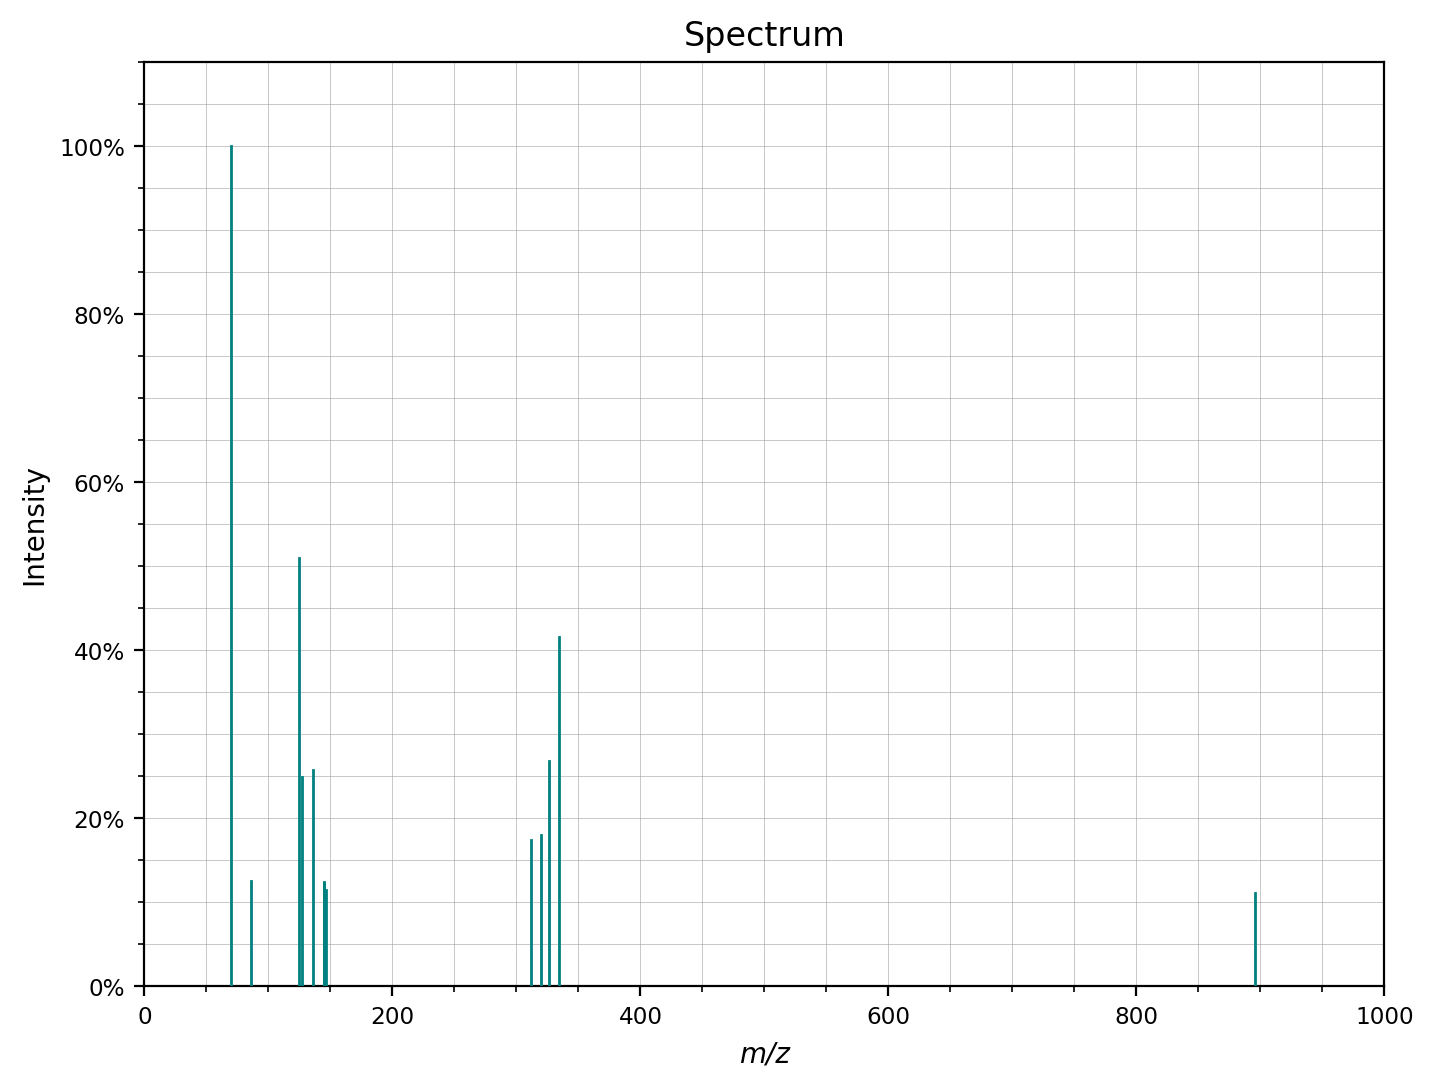

In [6]:
i = 23
print(motif_spectra[i].peaks.mz)
print("TOP 3 frags: ", heapq.nlargest(3, list(zip(motif_spectra[i].peaks.mz, motif_spectra[i].peaks.intensities)), key = lambda x: x[1]))
print("TOP 3 losses: ", heapq.nlargest(3, list(zip(motif_spectra[i].losses.mz, motif_spectra[i].losses.intensities)), key = lambda x: x[1]))
motif_spectra[i].plot()

### New Part: Use MassQL to search for matches

In [7]:
from MassQL_annotation import initialize_massql_DB
from MassQL_annotation import add_column
from MassQL_annotation import search_massql_DB

import pandas as pd

In [8]:
spectra_path_GNPS = r"C:\Users\dietr004\Documents\PhD\computational mass spectrometry\Spec2Struc\Project_SubstructureIdentification\raw_data\GNPS\cleaned_spectra_min_5_peaks.mgf"

In [9]:
## initialize new DB

#ms1_df, ms2_df = initialize_massql_DB(spectra_path_GNPS)
#ms1_df.to_parquet("ms1_massql.parquet")
#ms2_df.to_parquet("ms2_massql.parquet")

In [10]:
ms1_df = pd.read_parquet("ms1_massql.parquet")
ms2_df = pd.read_parquet("ms2_massql.parquet")

In [11]:
filename = spectra_path_GNPS[:-4] + "_corrected_scans.mgf"

----

In [63]:
input_query = "QUERY scaninfo(MS2DATA) WHERE MS2PROD=70.04:TOLERANCEMZ=0.01 AND MS2PROD=125.02:TOLERANCEMZ=0.01 AND MS2PROD=334.17:TOLERANCEMZ=0.01"

In [58]:
input_query = "QUERY scaninfo(MS2DATA) WHERE MS2PROD=158.98:TOLERANCEMZ=0.01 AND MS2PROD=(70.04 OR 72.04):TOLERANCEMZ=0.01"

In [64]:
results_df, matched_smiles = search_massql_DB(filename, input_query, ms1_df, ms2_df)

TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


In [65]:
matched_smiles

['CC1CC(=O)C/2=C(O1)/OC3(C)CCC4C(C)(C)C5OC5C(=O)C4(C)C3C2',
 'CC(C)C1CCC(C1(CN2C=NC=N2)O)CC3=CC=C(C=C3)Cl',
 'Cc1cc(O)c2c(c1)C(=O)c1cc(O)cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c1C2=O',
 'C=C(C)C(=O)O[C@H]1[C@H]2C(=C)C(=O)O[C@@H]2/C=C(\\CO)CC/C=C(/C=O)[C@@H]1O',
 'C=C(C)C(=O)O[C@H]1[C@H]2C(=C)C(=O)O[C@@H]2/C=C(\\CO)CC/C=C(/C=O)[C@@H]1O']

In [66]:
results_df

,scan,precmz,ms1scan,rt,charge,i,i_norm,mslevel,i_norm_ms1
0,16323,0,0,0,1,16.520662,1.0,2,NaN
1,23149,0,0,0,1,3.470542,1.0,2,NaN
2,238333,0,0,0,1,28.416342,1.0,2,NaN
3,243193,0,0,0,1,45.291312,1.0,2,NaN
4,243194,0,0,0,1,37.847925,1.0,2,NaN


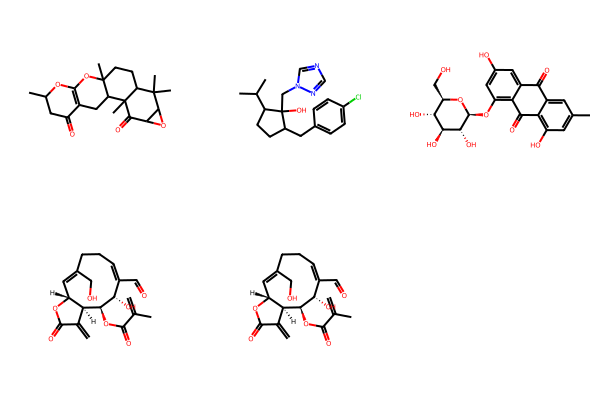

In [67]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in matched_smiles])

## include no statements. certain structures not in molecule. For example OH Groups related stuff; sugars and steroids in the upper case!!

### A motif would be than an massql query!!!

### if not completly clean possible: Add a false positive rate!!!